<h1>Setting up the environment and the dataset<h1>

In [2]:
# Importing necessary libraries
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras import Model
from keras import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
import keras_tuner as kt
from sklearn.metrics import zero_one_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

In [3]:
# Setting up the path to locate the dataset
PATH = '/Users/matteocastagna/Documents/Università/Magistrale/1_semestre_2/statistical method for machine learning/progetto/dataset'
data_dir = pathlib.Path(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Number of images in the dataset: {image_count}')

Number of images in the dataset: 5182


In [5]:
# Setting up dimensions of the images that will be fed to the network and number epochs for training (anf hyperparameter
# tuning ) and fine tuning
IMG_HEIGHT = 120
IMG_WIDTH = 120
INITIAL_EPOCHS = 5 # number of epochs used for training (without fine tuning)
TOTAL_EPOCHS = 2 * INITIAL_EPOCHS # number of epochs used for training (with fine tuning)
TUNING_EPOCHS = INITIAL_EPOCHS # number of epochs used for hyperparameter tuning
RANDOM_SEED = 100

# Creating the dataset as a tf.data.Dataset. Even if later the training set etc. will be converted to numpy array, loading the dataset
# this way and then converting is still faster than using os to load all the images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode = 'rgb',
  shuffle = False,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = None # The batch size is set to None so it can be tuned later
)

Found 5182 files belonging to 2 classes.


In [6]:
# Printing dataset classes
class_names = ds.class_names
print(f'First class: {class_names[0]}')
print(f'Second class: {class_names[1]}')

First class: chihuahua
Second class: muffin


In [7]:
# Shuffling the dataset
ds = ds.shuffle(buffer_size = ds.cardinality(), reshuffle_each_iteration = False, seed = RANDOM_SEED)

# Splitting the dataset into train and validation set
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size = 0.8, shuffle = False)

# Printing the cardinality of train and validation set
train_card = tf.data.experimental.cardinality(train_ds)
print(f'Training set cardinality: {train_card.numpy()}')
val_card = tf.data.experimental.cardinality(val_ds)
print(f'Validation set cardinality: {val_card.numpy()}')

Training set cardinality: 4146
Validation set cardinality: 1036


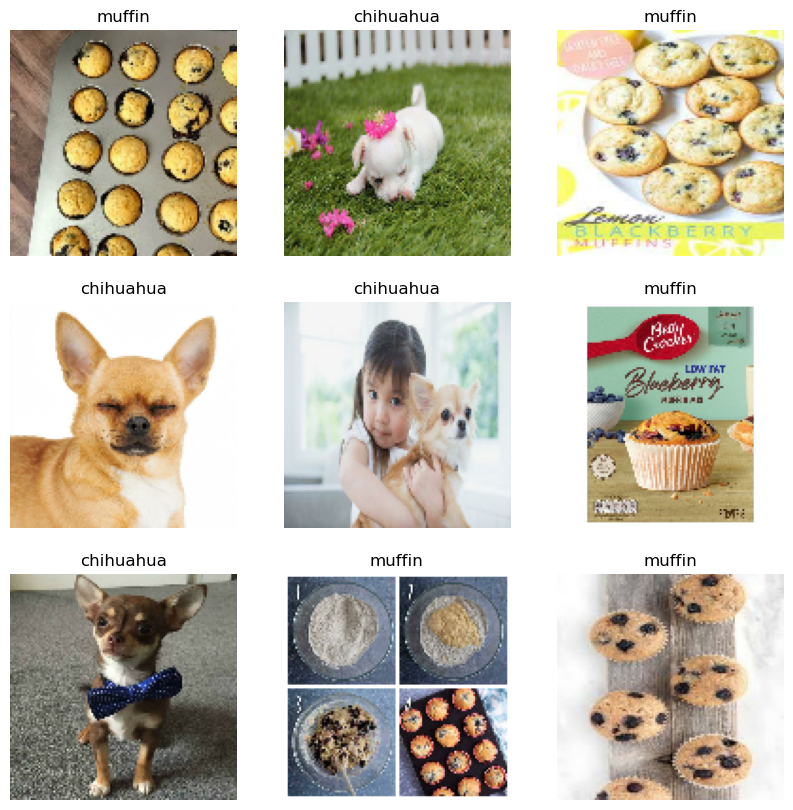

In [8]:
# Showing the first 9 images from the training set
plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[labels])
    plt.axis("off")
    i = i + 1

<h1>Setting up the network and performing hyperparameters tuning<h1>

In [9]:
# Keras-tuner HyperModel class let encapsulate a model for sharing and reuse, an hypermodel can be passed to a keras tuner to perform
# keras automatic hyperparameters tuning
class MyHypermodel(kt.HyperModel):
    
    def build(self, hp):
        
        input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
        inputs = Input(shape = input_shape)
        
        # Rescaling layer
        x = layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))(inputs)
        
        # Preparing the keras pre-trained VGG16, only the CNN part is used while the classification head is trashed
        # as the problem use only 2 classes
        x = VGG16(
            include_top = False, weights = 'imagenet', input_shape=([IMG_HEIGHT, IMG_WIDTH, 3]),
            pooling = 'avg', input_tensor = x)
        
        # Making the whole VGG16 temporarely not trainable
        x.trainable = False
        
        # Fully connected classification head
        x = layers.Flatten()(x.output)
        x = layers.Dense(16)(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(1)(x)
        x = layers.Activation('sigmoid')(x)
        
        model = Model(inputs, x)
              
        model.compile(
            # Tuning the learning rate for the optimizer, choosing an optimal value from 0.1, 0.01 or 0.001
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3])),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = ['accuracy']
        )
        
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tuning the batch size, choosing an optimal value from 16, 32 or 48
            batch_size = hp.Int("batch_size", 16, 48, step = 16),
            **kwargs,
        )

# As when loading the dataset previously the batch size was setted to None, the dataset is made of single examples (height x width x channel),
# but functions such as tuner.search(*), fit(*), etc. expect as input something like (batch_size x height x width x channel);
# therefore I convert training, and validation set from tensorflow dataset to numpy array and split samples from labels,
# then feed the model with them instead of the tensorflow dataset
X_train = np.asarray(list(train_ds.map(lambda x, y: x)))
Y_train = np.asarray(list(train_ds.map(lambda x, y: y)))

X_val= np.asarray(list(val_ds.map(lambda x, y: x)))
Y_val = np.asarray(list(val_ds.map(lambda x, y: y)))

del train_ds, val_ds

# The keras GridSearch tuner just iterates over all the hyperparameters combinations, in this case we would get 9 trials total
tuner = kt.GridSearch(
    MyHypermodel(),
    objective = 'val_accuracy',
    directory = 'vgg/best_hyperparameters',
    project_name = 'tuning',
    overwrite = True,
    seed = RANDOM_SEED
)

# Early stopping for the hyperparameter tuning
stop_early = EarlyStopping(monitor='val_loss', patience = 3, verbose = 1)

tuner.search(X_train, Y_train,
             epochs = TUNING_EPOCHS,
             callbacks = [stop_early],
             validation_data = (X_val, Y_val),
             shuffle = False,
)

# Printing best hyperparameters
print("", end="\n")
print(f'Best learning rate: {tuner.get_best_hyperparameters()[0]["learning_rate"]}')
print(f'Best batch size: {tuner.get_best_hyperparameters()[0]["batch_size"]}')

Trial 9 Complete [00h 00m 53s]
val_accuracy: 0.9565637111663818

Best val_accuracy So Far: 0.9633204340934753
Total elapsed time: 00h 07m 49s
INFO:tensorflow:Oracle triggered exit

Best learning rate: 0.01
Best batch size: 48


In [10]:
# Plotting the performances of the models generated by the various combinations of hyperparameters
# Plotting both the parallel plot and the dataframe with the hyperparameters and validation accuracy score for a more
# comprehensive visualization
import plotly.express as px
import pandas as pd

l_trial = []
l_lr = []
l_bs = []
l_score = []
for trial in tuner.oracle.trials.values():
    l_trial.append(int(trial.trial_id) + 1)
    l_lr.append(trial.hyperparameters["learning_rate"])
    l_bs.append(trial.hyperparameters["batch_size"])
    l_score.append(trial.score)
    
df = pd.DataFrame(list(zip(l_trial, l_lr, l_bs, l_score)),
               columns =['Trial #', 'Learning rate', 'Batch size', 'Validation accuracy'])

# parallel_categories instead of parallel_coordinates helps visualize better the results of the tuning in terms of tracing the
# hyperparameters of each trial. The lighter (yellow) is the color the better the score of the corresponding trial is, the
# darker (blue) is the color the worst the score of the corresponding trial is
fig = px.parallel_categories(df, color="Validation accuracy", labels={'Trial #': 'Trial #', 'Learning rate' : 'Learning rate',
                                          'Batch size' : 'Batch size', 'Validation accuracy' :  'Validation accuracy'})

fig.update(layout_coloraxis_showscale=False)
fig.show()

df

Trial #  Learning rate  Batch size  Validation accuracy
0        1          0.100          16             0.948842
1        2          0.100          32             0.955598
2        3          0.100          48             0.962355
3        4          0.010          16             0.962355
4        5          0.010          32             0.958494
5        6          0.010          48             0.963320
6        7          0.001          16             0.962355
7        8          0.001          32             0.956564
8        9          0.001          48             0.956564

<h1>5-Fold Cross Validation<h1>

In [11]:
# Setting up 5-fold cross validation
kfold = KFold(n_splits = 5, shuffle = False)

# Splitting samples from labels of the dataset
X = np.asarray(list(ds.map(lambda x, y: x)))
Y = np.asarray(list(ds.map(lambda x, y: y)))

del X_train, Y_train, X_val, Y_val

In [12]:
i = 0
model_history_train = [] # List to save train losses and accuracies of the models over each epoch
model_history_val = [] # List to save validation losses and accuracies of the models over each epoch
# Y_pred_list and Y_val_list are used later to plot the confusion matrix of the 5-fold cross validation models
Y_pred_list = [] # List to save each model prediction during validation
Y_val_list = [] # List to save validation set labels of each model
n_chihuahua_muffin = [] # List to save the number of chiahuahua and muffin examples per partition to look later if they were balanced

for train_index, test_index in kfold.split(X):
    
    ##############################################
    ################## Training ##################
    ##############################################
    
    print(f'Fold {i + 1}')
    
    X_train, X_val = X[train_index], X[test_index] # Building the training set
    Y_train, Y_val = Y[train_index], Y[test_index] # Building the validation set
    
    # Creating (substituting to an already existing one) the directory that will contain the checkpoints
    checkpoint_path = f"vgg/bst_mdl_{i + 1}/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    # Retrieving the model with the best hyperparameters
    model = tuner.get_best_models()[0]
    
    # Preparing keras callback to save the best model. The new weights of the model will be saved each time
    # its accuracy is better then the previous one.
    # Weights cannot be saved in the much more handy h5 format as the network has not all the parameters trainable,
    # therefore when loading the h5 file for fine tuning, where new layers of network will be trainable, the number
    # of parameters saved previously and the new number of trainable parameters missmatch and cause an error.
    model_checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only = True,
                                                save_best_only = True, monitor = 'accuracy', mode = 'max', verbose = 1)
    
    # Early stopping callback
    model_earlystopping_callback = EarlyStopping(monitor = 'loss', patience = 3, verbose = 1)

    fitted = model.fit(
        X_train, Y_train,
        epochs = INITIAL_EPOCHS,
        callbacks = [model_checkpoint_callback, model_earlystopping_callback],
        shuffle = False,
        batch_size = tuner.get_best_hyperparameters()[0]["batch_size"],
        verbose = 2
    )
    
    # Saving accuracy and loss copmuted over each epoch, during training for the current model
    acc = fitted.history['accuracy']
    loss = fitted.history['loss']
    
    ###############################################
    ################# Fine Tuning #################
    ###############################################
    
    # Loading the weights that have given the best performances until now
    model.load_weights(checkpoint_path)

    # Un-freezing the VGG16 model and then freezing only the bottom layers in order to make the last layers trainable
    model.trainable = True
    n_layers_to_not_fn = 8 # Arbitrarily chosen
    for layer in model.layers[:n_layers_to_not_fn]:
        layer.trainable = False

    # As we are fine-tuning, this time the learning rate is manually set to be small, the batch size
    # will remain the one obtained during the hyperparameter tuning process
    model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
    )
    
    fitted_ft = model.fit(
        X_train, Y_train,
        epochs = TOTAL_EPOCHS,
        initial_epoch = fitted.epoch[-1] + 1,
        callbacks = [model_checkpoint_callback, model_earlystopping_callback],
        shuffle = False,
        batch_size = tuner.get_best_hyperparameters()[0]["batch_size"],
        verbose = 2
    )
    
    # Updating saved training losses and accuracies after fine tuning, those score will be plotted later
    acc += fitted_ft.history['accuracy']
    loss += fitted_ft.history['loss']
    
    # Saving training losses and accuracies of each mdoel
    trained = {'loss': loss, 'accuracy': acc}
    model_history_train.append(trained)
    
    ##############################################
    ################# Validation #################
    ##############################################
    
    model.load_weights(checkpoint_path)
    
    Y_hat = model.predict(
        X_val,
        batch_size = 1,
        verbose = 2,
    )
    
    # saving predictions and original labels to plot confusion matrix later
    Y_pred = np.rint(Y_hat)
    Y_pred_list.append(Y_pred)
    Y_val_list.append(Y_val)
    
    # Saving validation losses and accuracies of each model
    predicted = {'loss': [], 'accuracy': []}
    predicted['loss'].append(zero_one_loss(Y_val, Y_pred))
    predicted['accuracy'].append(accuracy_score(Y_val, Y_pred))
    model_history_val.append(predicted)
    
    # Saving the number of chiahuahua and muffin examples per partition to look later if they were balanced
    n_muffin_train = np.count_nonzero(Y_train)
    n_chihuahua_train = Y_train.size - n_muffin_train
    n_muffin_val = np.count_nonzero(Y_val)
    n_chihuahua_val = Y_val.size - n_muffin_val
    n_dict = {'train_chihuahua': n_chihuahua_train, 'train_muffin': n_muffin_train,
            'val_chihuahua': n_chihuahua_val, 'val_muffin': n_muffin_val}
    n_chihuahua_muffin.append(n_dict)
    
    print("", end="\n\n\n")
    
    i += 1
    

Fold 1
Epoch 1/5


2023-09-11 14:55:34.851932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.96478, saving model to vgg/bst_mdl_1/cp.ckpt
87/87 - 9s - loss: 0.1005 - accuracy: 0.9648 - 9s/epoch - 103ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.96478 to 0.97467, saving model to vgg/bst_mdl_1/cp.ckpt
87/87 - 8s - loss: 0.0730 - accuracy: 0.9747 - 8s/epoch - 93ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.97467 to 0.98118, saving model to vgg/bst_mdl_1/cp.ckpt
87/87 - 8s - loss: 0.0584 - accuracy: 0.9812 - 8s/epoch - 93ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.98118 to 0.98528, saving model to vgg/bst_mdl_1/cp.ckpt
87/87 - 8s - loss: 0.0487 - accuracy: 0.9853 - 8s/epoch - 93ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.98528 to 0.98721, saving model to vgg/bst_mdl_1/cp.ckpt
87/87 - 8s - loss: 0.0418 - accuracy: 0.9872 - 8s/epoch - 93ms/step
Epoch 6/10


2023-09-11 14:56:17.266339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: accuracy did not improve from 0.98721
87/87 - 23s - loss: 0.5156 - accuracy: 0.9045 - 23s/epoch - 262ms/step
Epoch 7/10

Epoch 7: accuracy did not improve from 0.98721
87/87 - 22s - loss: 0.0784 - accuracy: 0.9701 - 22s/epoch - 250ms/step
Epoch 8/10

Epoch 8: accuracy did not improve from 0.98721
87/87 - 22s - loss: 0.0568 - accuracy: 0.9793 - 22s/epoch - 250ms/step
Epoch 9/10

Epoch 9: accuracy did not improve from 0.98721
87/87 - 22s - loss: 0.0453 - accuracy: 0.9819 - 22s/epoch - 249ms/step
Epoch 10/10

Epoch 10: accuracy improved from 0.98721 to 0.99252, saving model to vgg/bst_mdl_1/cp.ckpt
87/87 - 22s - loss: 0.0252 - accuracy: 0.9925 - 22s/epoch - 254ms/step


2023-09-11 14:58:07.536013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1037/1037 - 8s - 8s/epoch - 8ms/step



Fold 2
Epoch 1/5


2023-09-11 14:58:17.578286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.96309, saving model to vgg/bst_mdl_2/cp.ckpt
87/87 - 9s - loss: 0.0946 - accuracy: 0.9631 - 9s/epoch - 100ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.96309 to 0.96815, saving model to vgg/bst_mdl_2/cp.ckpt
87/87 - 8s - loss: 0.0849 - accuracy: 0.9682 - 8s/epoch - 93ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.96815 to 0.97177, saving model to vgg/bst_mdl_2/cp.ckpt
87/87 - 8s - loss: 0.0736 - accuracy: 0.9718 - 8s/epoch - 93ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.97177 to 0.97587, saving model to vgg/bst_mdl_2/cp.ckpt
87/87 - 8s - loss: 0.0664 - accuracy: 0.9759 - 8s/epoch - 93ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.97587 to 0.97780, saving model to vgg/bst_mdl_2/cp.ckpt
87/87 - 8s - loss: 0.0639 - accuracy: 0.9778 - 8s/epoch - 93ms/step
Epoch 6/10


2023-09-11 14:58:59.602713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: accuracy did not improve from 0.97780
87/87 - 23s - loss: 0.5532 - accuracy: 0.8487 - 23s/epoch - 261ms/step
Epoch 7/10

Epoch 7: accuracy did not improve from 0.97780
87/87 - 22s - loss: 0.1086 - accuracy: 0.9587 - 22s/epoch - 250ms/step
Epoch 8/10

Epoch 8: accuracy did not improve from 0.97780
87/87 - 22s - loss: 0.0657 - accuracy: 0.9742 - 22s/epoch - 249ms/step
Epoch 9/10

Epoch 9: accuracy improved from 0.97780 to 0.98649, saving model to vgg/bst_mdl_2/cp.ckpt
87/87 - 22s - loss: 0.0394 - accuracy: 0.9865 - 22s/epoch - 254ms/step
Epoch 10/10

Epoch 10: accuracy did not improve from 0.98649
87/87 - 22s - loss: 0.0361 - accuracy: 0.9855 - 22s/epoch - 250ms/step


2023-09-11 15:00:49.862772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1037/1037 - 8s - 8s/epoch - 7ms/step



Fold 3
Epoch 1/5


2023-09-11 15:00:59.900987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.96671, saving model to vgg/bst_mdl_3/cp.ckpt
87/87 - 9s - loss: 0.0928 - accuracy: 0.9667 - 9s/epoch - 102ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.96671 to 0.96792, saving model to vgg/bst_mdl_3/cp.ckpt
87/87 - 8s - loss: 0.0765 - accuracy: 0.9679 - 8s/epoch - 93ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.96792 to 0.97685, saving model to vgg/bst_mdl_3/cp.ckpt
87/87 - 8s - loss: 0.0616 - accuracy: 0.9768 - 8s/epoch - 93ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.97685 to 0.98143, saving model to vgg/bst_mdl_3/cp.ckpt
87/87 - 8s - loss: 0.0513 - accuracy: 0.9814 - 8s/epoch - 93ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.98143 to 0.98529, saving model to vgg/bst_mdl_3/cp.ckpt
87/87 - 8s - loss: 0.0457 - accuracy: 0.9853 - 8s/epoch - 93ms/step
Epoch 6/10


2023-09-11 15:01:42.512007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: accuracy did not improve from 0.98529
87/87 - 23s - loss: 0.4134 - accuracy: 0.8874 - 23s/epoch - 264ms/step
Epoch 7/10

Epoch 7: accuracy did not improve from 0.98529
87/87 - 22s - loss: 0.0690 - accuracy: 0.9727 - 22s/epoch - 250ms/step
Epoch 8/10

Epoch 8: accuracy improved from 0.98529 to 0.99059, saving model to vgg/bst_mdl_3/cp.ckpt
87/87 - 22s - loss: 0.0272 - accuracy: 0.9906 - 22s/epoch - 255ms/step
Epoch 9/10

Epoch 9: accuracy did not improve from 0.99059
87/87 - 22s - loss: 0.0234 - accuracy: 0.9901 - 22s/epoch - 250ms/step
Epoch 10/10

Epoch 10: accuracy did not improve from 0.99059
87/87 - 22s - loss: 0.0300 - accuracy: 0.9884 - 22s/epoch - 251ms/step


2023-09-11 15:03:33.390942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 8s - 8s/epoch - 7ms/step



Fold 4
Epoch 1/5


2023-09-11 15:03:43.448005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.96551, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 9s - loss: 0.1010 - accuracy: 0.9655 - 9s/epoch - 102ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.96551 to 0.96768, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 8s - loss: 0.0794 - accuracy: 0.9677 - 8s/epoch - 93ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.96768 to 0.97443, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 8s - loss: 0.0649 - accuracy: 0.9744 - 8s/epoch - 93ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.97443 to 0.98312, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 8s - loss: 0.0514 - accuracy: 0.9831 - 8s/epoch - 93ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.98312 to 0.98577, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 8s - loss: 0.0418 - accuracy: 0.9858 - 8s/epoch - 93ms/step
Epoch 6/10


2023-09-11 15:04:25.599475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: accuracy did not improve from 0.98577
87/87 - 23s - loss: 0.4843 - accuracy: 0.8922 - 23s/epoch - 262ms/step
Epoch 7/10

Epoch 7: accuracy did not improve from 0.98577
87/87 - 22s - loss: 0.0792 - accuracy: 0.9718 - 22s/epoch - 250ms/step
Epoch 8/10

Epoch 8: accuracy did not improve from 0.98577
87/87 - 22s - loss: 0.0518 - accuracy: 0.9824 - 22s/epoch - 250ms/step
Epoch 9/10

Epoch 9: accuracy improved from 0.98577 to 0.98601, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 22s - loss: 0.0367 - accuracy: 0.9860 - 22s/epoch - 254ms/step
Epoch 10/10

Epoch 10: accuracy improved from 0.98601 to 0.98818, saving model to vgg/bst_mdl_4/cp.ckpt
87/87 - 22s - loss: 0.0355 - accuracy: 0.9882 - 22s/epoch - 255ms/step


2023-09-11 15:06:16.320867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 8s - 8s/epoch - 7ms/step



Fold 5
Epoch 1/5


2023-09-11 15:06:26.223739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.97130, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 9s - loss: 0.0767 - accuracy: 0.9713 - 9s/epoch - 102ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.97130 to 0.97419, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 8s - loss: 0.0676 - accuracy: 0.9742 - 8s/epoch - 93ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.97419 to 0.97853, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 8s - loss: 0.0559 - accuracy: 0.9785 - 8s/epoch - 97ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.97853 to 0.97974, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 8s - loss: 0.0515 - accuracy: 0.9797 - 8s/epoch - 93ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.97974 to 0.98649, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 8s - loss: 0.0342 - accuracy: 0.9865 - 8s/epoch - 96ms/step
Epoch 6/10


2023-09-11 15:07:08.816786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: accuracy did not improve from 0.98649
87/87 - 23s - loss: 0.3974 - accuracy: 0.9045 - 23s/epoch - 266ms/step
Epoch 7/10

Epoch 7: accuracy did not improve from 0.98649
87/87 - 22s - loss: 0.0712 - accuracy: 0.9720 - 22s/epoch - 255ms/step
Epoch 8/10

Epoch 8: accuracy did not improve from 0.98649
87/87 - 22s - loss: 0.0772 - accuracy: 0.9715 - 22s/epoch - 253ms/step
Epoch 9/10

Epoch 9: accuracy improved from 0.98649 to 0.99252, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 22s - loss: 0.0216 - accuracy: 0.9925 - 22s/epoch - 254ms/step
Epoch 10/10

Epoch 10: accuracy improved from 0.99252 to 0.99445, saving model to vgg/bst_mdl_5/cp.ckpt
87/87 - 22s - loss: 0.0151 - accuracy: 0.9945 - 22s/epoch - 257ms/step


2023-09-11 15:09:00.831380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 8s - 8s/epoch - 8ms/step





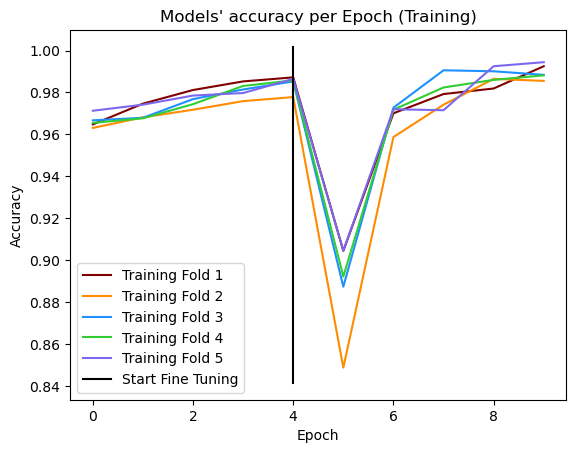

In [13]:
plt.title('Models\' accuracy per Epoch (Training)')
plt.plot(model_history_train[0]['accuracy'], label='Training Fold 1', color = 'maroon', linestyle = 'solid')
plt.plot(model_history_train[1]['accuracy'], label='Training Fold 2', color = 'darkorange', linestyle = 'solid')
plt.plot(model_history_train[2]['accuracy'], label='Training Fold 3', color = 'dodgerblue', linestyle = 'solid')
plt.plot(model_history_train[3]['accuracy'], label='Training Fold 4', color = 'limegreen', linestyle = 'solid')
plt.plot(model_history_train[4]['accuracy'], label='Training Fold 5', color = 'mediumslateblue', linestyle = 'solid')
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning', color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

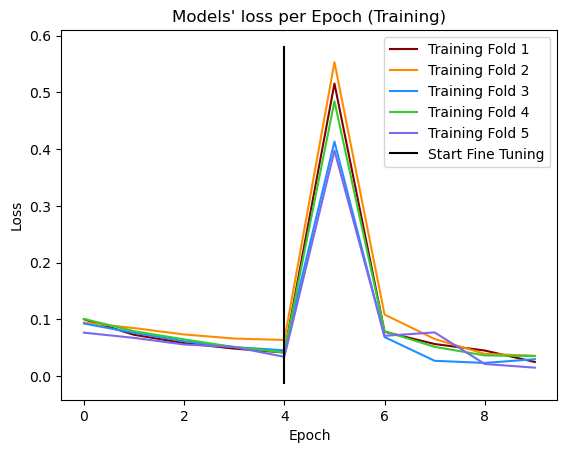

In [14]:
plt.title('Models\' loss per Epoch (Training)')
plt.plot(model_history_train[0]['loss'], label='Training Fold 1', color = 'maroon', linestyle = 'solid')
plt.plot(model_history_train[1]['loss'], label='Training Fold 2', color = 'darkorange', linestyle = 'solid')
plt.plot(model_history_train[2]['loss'], label='Training Fold 3', color = 'dodgerblue', linestyle = 'solid')
plt.plot(model_history_train[3]['loss'], label='Training Fold 4', color = 'limegreen', linestyle = 'solid')
plt.plot(model_history_train[4]['loss'], label='Training Fold 5', color = 'mediumslateblue', linestyle = 'solid')
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning', color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---------- Model 1 ---------
Recall score: 0.8926441351888668
Precision score: 0.9977777777777778
F1-score : 0.9422875131164743

---------- Model 2 ---------
Recall score: 0.9791666666666666
Precision score: 0.9828897338403042
F1-score : 0.9810246679316889

---------- Model 3 ---------
Recall score: 0.9941747572815534
Precision score: 0.8812392426850258
F1-score : 0.9343065693430656

---------- Model 4 ---------
Recall score: 0.9905482041587902
Precision score: 0.9886792452830189
F1-score : 0.9896128423040605

---------- Model 5 ---------
Recall score: 0.990530303030303
Precision score: 0.9812382739212008
F1-score : 0.9858623939679547



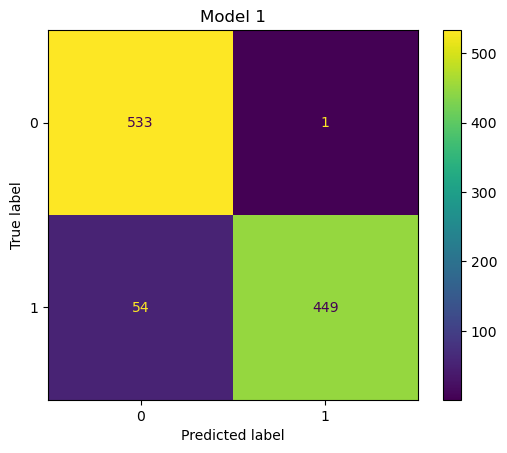

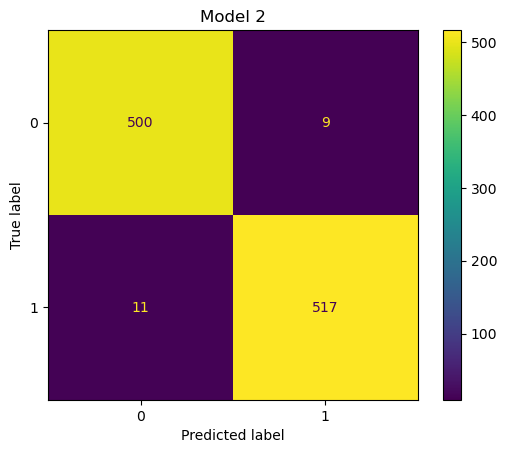

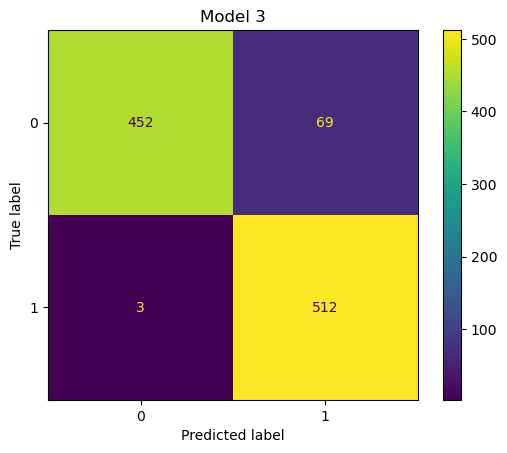

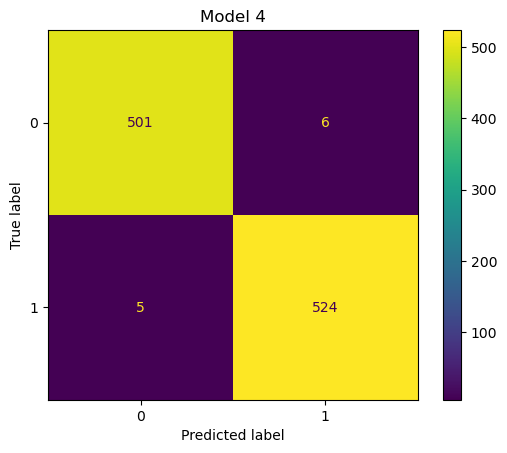

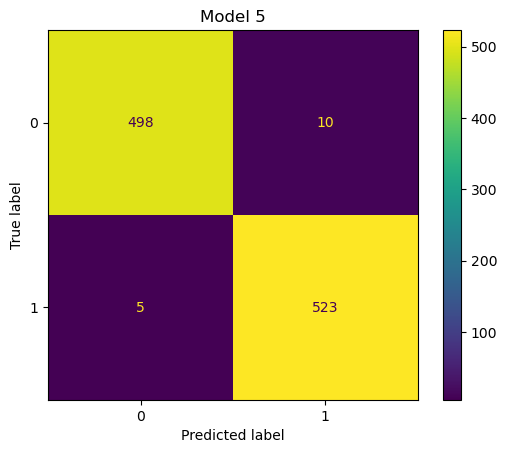

In [15]:
# Printing confusion matrices for the validation folds
i = 0
for pred in Y_pred_list:
    print(f"---------- Model {i + 1} ---------")
    print(f'Recall score: {recall_score(Y_val_list[i], pred)}')
    print(f'Precision score: {precision_score(Y_val_list[i], pred)}')
    print(f'F1-score : {f1_score(Y_val_list[i], pred)}')
    print("", end="\n")
    cm = confusion_matrix(Y_val_list[i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    plt.title(f"Model {i+1}")
    i += 1

In [16]:
# Printing zero-one loss and accuracy on the validations folds
i = 1
for stats in model_history_val:
    print(f"---------- Model {i} ---------")
    print(f"Zero-one loss: {stats['loss'][0]}")
    print(f"Accuracy: {stats['accuracy'][0]}")
    print("", end="\n\n")
    i += 1

---------- Model 1 ---------
Zero-one loss: 0.05303760848601735
Accuracy: 0.9469623915139826


---------- Model 2 ---------
Zero-one loss: 0.01928640308582452
Accuracy: 0.9807135969141755


---------- Model 3 ---------
Zero-one loss: 0.06949806949806947
Accuracy: 0.9305019305019305


---------- Model 4 ---------
Zero-one loss: 0.010617760617760652
Accuracy: 0.9893822393822393


---------- Model 5 ---------
Zero-one loss: 0.014478764478764505
Accuracy: 0.9855212355212355




<h1>Explainability<h1>

In [17]:
i = 1
for n_per_model in n_chihuahua_muffin:
    print(f'Fold {i}')
    print(f'Percentage of chihuahua examples (train) {i + 1}: { round( ( n_per_model["train_chihuahua"] / ( n_per_model["train_chihuahua"] + n_per_model["train_muffin"] ) ) * 100 ) }')
    print(f'Percentage of muffin examples (train) {i + 1}: { round( ( n_per_model["train_muffin"] / ( n_per_model["train_chihuahua"] + n_per_model["train_muffin"] ) ) * 100 ) }')
    print(f'Percentage of chihuahua examples (validation) {i + 1}: { round( ( n_per_model["val_chihuahua"] / ( n_per_model["val_chihuahua"] + n_per_model["val_muffin"] ) ) * 100 ) }')
    print(f'Percentage of muffin examples (validation) {i + 1}: { round( ( n_per_model["val_muffin"] / ( n_per_model["val_chihuahua"] + n_per_model["val_muffin"] ) ) * 100 ) }')
    print("", end="\n")
    i += 1

Fold 1
Percentage of chihuahua examples (train) 2: 49
Percentage of muffin examples (train) 2: 51
Percentage of chihuahua examples (validation) 2: 51
Percentage of muffin examples (validation) 2: 49

Fold 2
Percentage of chihuahua examples (train) 3: 50
Percentage of muffin examples (train) 3: 50
Percentage of chihuahua examples (validation) 3: 49
Percentage of muffin examples (validation) 3: 51

Fold 3
Percentage of chihuahua examples (train) 4: 50
Percentage of muffin examples (train) 4: 50
Percentage of chihuahua examples (validation) 4: 50
Percentage of muffin examples (validation) 4: 50

Fold 4
Percentage of chihuahua examples (train) 5: 50
Percentage of muffin examples (train) 5: 50
Percentage of chihuahua examples (validation) 5: 49
Percentage of muffin examples (validation) 5: 51

Fold 5
Percentage of chihuahua examples (train) 6: 50
Percentage of muffin examples (train) 6: 50
Percentage of chihuahua examples (validation) 6: 49
Percentage of muffin examples (validation) 6: 51



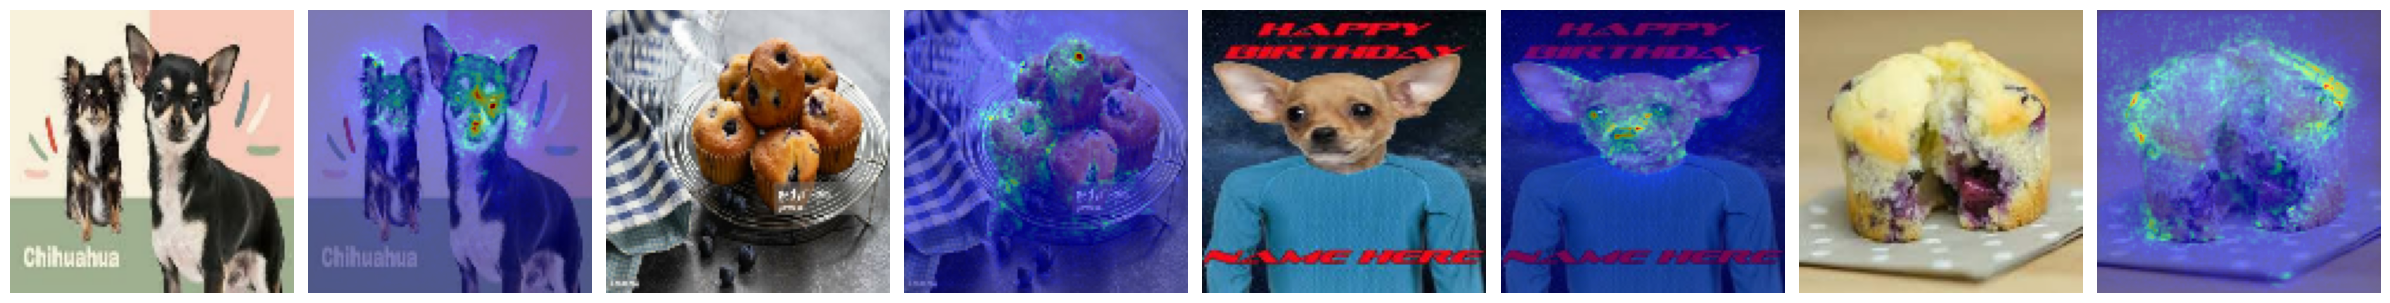

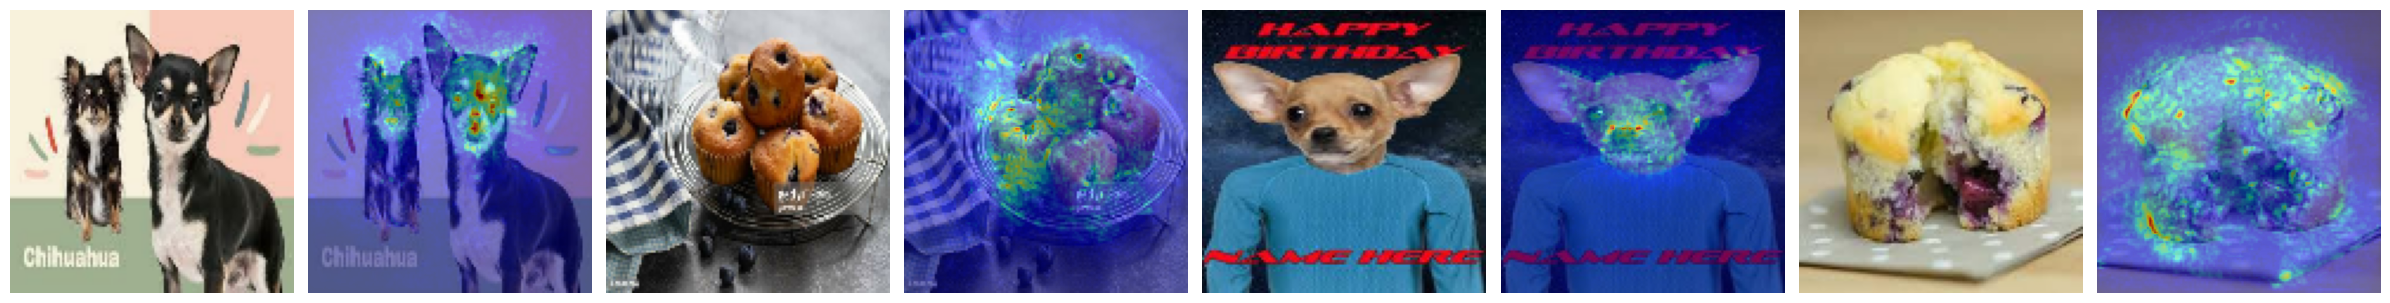

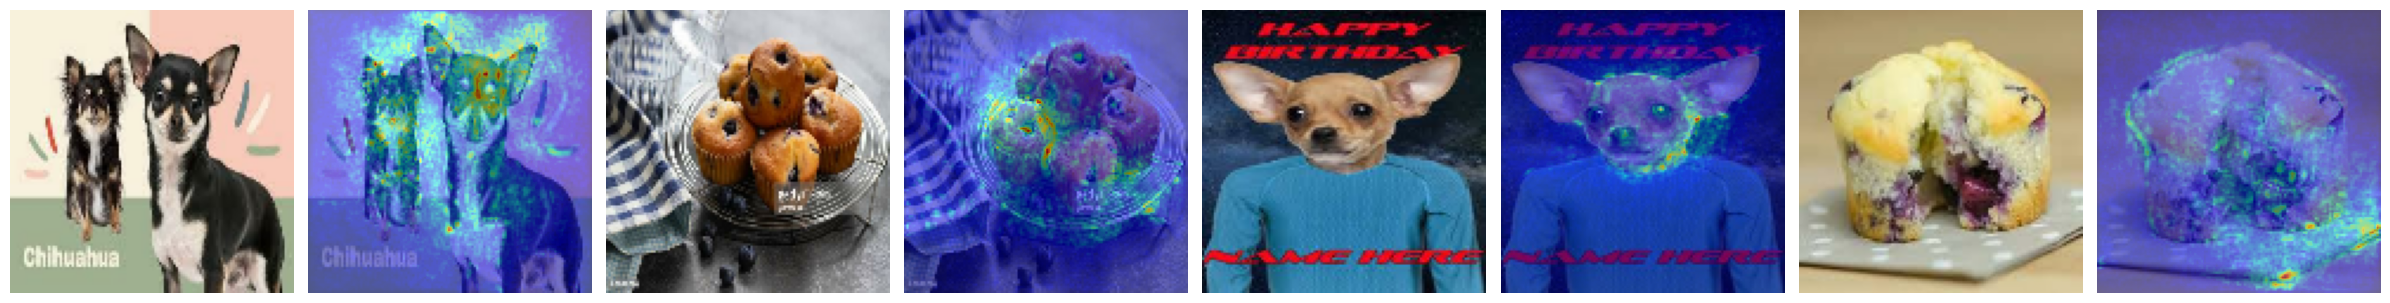

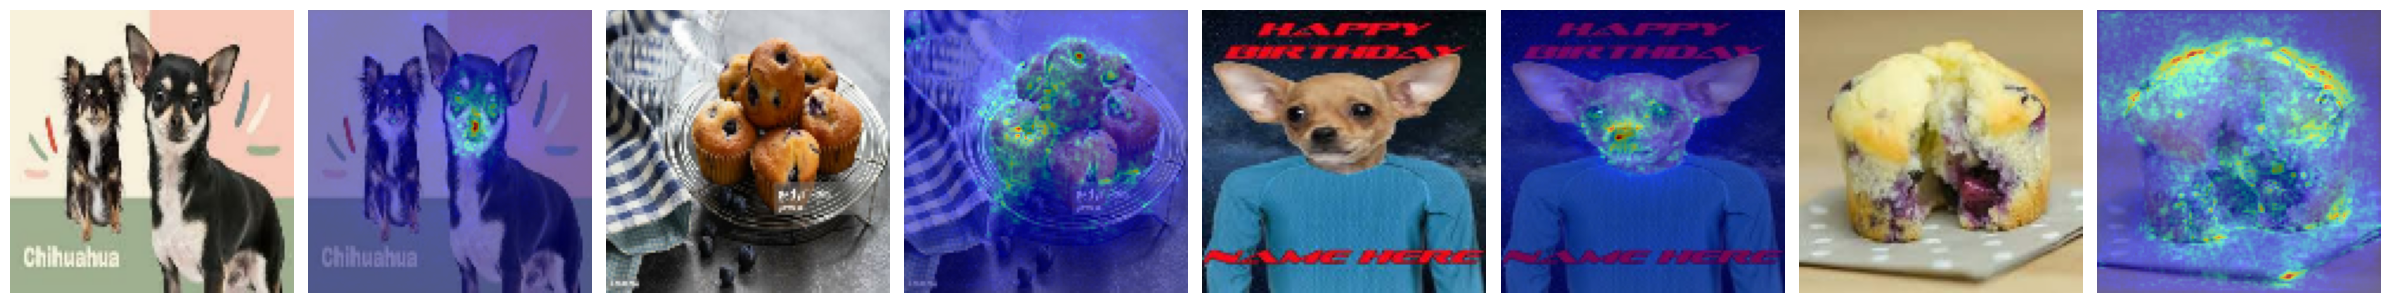

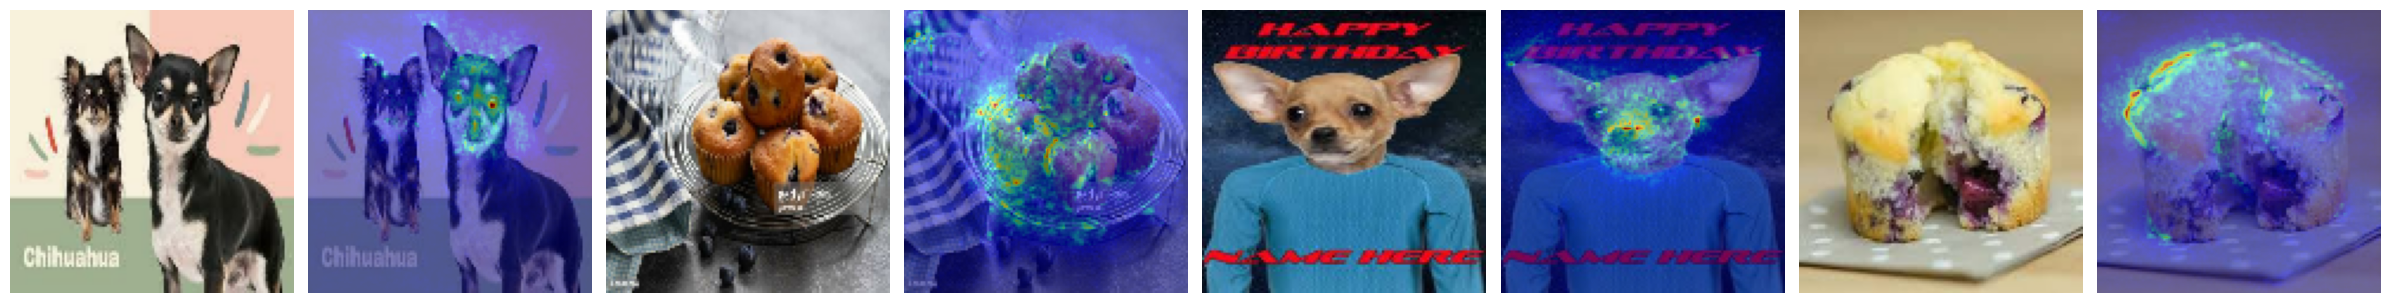

In [18]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.saliency import Saliency

# In the for loop, each one of the 5-cross validation model is retrieved. As they're only used for prediction by the function 'Saliency' and
# they're not used for training, there are some unused values, in particular the one about the optimizer (learning rate, beta_1, beta_2). Those
# cause tensorflow to raise unnecessary warnings in this context, therefore tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# is use to turn off tensorflow log messages to avoid the unnecessary warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

replace2linear = ReplaceToLinear()

i = 0
for i in range(5):
    
    model = tuner.get_best_models()[0]
    model.load_weights(f"vgg/bst_mdl_{i + 1}/cp.ckpt")

    saliency = Saliency(model,
                        model_modifier = replace2linear,
                        clone = True)

    score = BinaryScore([Y[2050], Y[2051], Y[2052], Y[2053]])
    img = X[2050:2054]
    saliency_map = saliency(score, img, smooth_samples = 20, smooth_noise = 0.2)

    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(24, 8))
    for i in range(4):
        ax[i * 2].imshow(img[i].astype("uint8"))
        ax[i * 2 + 1].imshow(img[i].astype("uint8"))
        ax[i * 2 + 1].imshow(saliency_map[i], cmap='jet', alpha=0.5)
        ax[i * 2].axis('off')
        ax[i * 2 + 1].axis('off')
    plt.tight_layout()
    plt.show()